In [1]:
import os
import argparse
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
import time
import torchvision.transforms.functional as F
import shutil
from torchvision.models import wide_resnet50_2

### **BTAD Dataset**
#### **1. 데이터셋 구성**
- **클래스**: `'01'`, `'02'`, `'03'` (3개의 제품 유형)
- **폴더 구조**:
  - `train/`: 학습 데이터
  - `test/`: 테스트 데이터
  - `ground_truth/`: 결함 마스크 데이터 (결함 위치를 표시)

---

#### **2. 사용 목적**
- **정상(normal)** 및 **비정상(anomalous)** 이미지를 기반으로 이상 탐지 모델을 학습.
- 데이터 정리 및 변환을 통해 PyTorch Dataset 클래스와 모델 학습에 적합한 형식으로 준비.

---

#### **3. 주요 기능**
- **데이터 정리**: 학습(`train`)과 테스트(`test`) 폴더 내 `ok`, `ko` 하위 폴더를 단순화.
- **결함 라벨링**: 결함 마스크를 기준으로 정상(0) 또는 결함(1)으로 분류.
- **데이터 증강**

---

#### **4. 데이터 준비 과정**
1. `btad_folder` 경로에 데이터셋을 저장.
2. `CreateBtadDataset` 함수를 통해 데이터 정리 및 구성.
3. 설정 파일(`config`)이 생성되면 데이터셋 준비 완료.


In [2]:
btad_folder = '/content/drive/MyDrive/BTech_Dataset_transformed'
btad_config_file = os.path.join(btad_folder, 'config')
BTAD_CLASS_NAMES = ['01', '02', '03']
ANOMALY_THRESHOLD = 0   # 결함을 판별하는 임계값 설정

In [3]:
def CreateBtadDataset():
    """
    BTAD 데이터셋을 준비하는 함수.

    1. 데이터셋 폴더가 존재하는지 확인
    2. 데이터셋 폴더의 구조를 정리하여 학습(train), 테스트(test), 및 결함 마스크(ground_truth) 폴더를 준비
    3. 작업이 완료되면 설정 파일(config)을 생성하여 데이터셋 준비가 완료되었음을 기록
    """
    try:
        for Class in BTAD_CLASS_NAMES:
            train_folder = os.path.join(btad_folder, Class, 'train')
            test_folder = os.path.join(btad_folder, Class, 'test')

            # Train 폴더 정리
            train_ok_folder = os.path.join(train_folder, 'ok')
            if os.path.exists(train_ok_folder):
                all_train_imgs = sorted(os.listdir(train_ok_folder))
                for img in all_train_imgs:
                    shutil.move(os.path.join(train_ok_folder, img), train_folder)
                shutil.rmtree(train_ok_folder)

            # Test 폴더 정리
            test_ok_folder = os.path.join(test_folder, 'ok')
            test_ko_folder = os.path.join(test_folder, 'ko')
            if os.path.exists(test_ko_folder):
                for img in sorted(os.listdir(test_ko_folder)):
                    shutil.move(os.path.join(test_ko_folder, img), test_folder)
                shutil.rmtree(test_ko_folder)
            if os.path.exists(test_ok_folder):
                for img in sorted(os.listdir(test_ok_folder)):
                    shutil.move(os.path.join(test_ok_folder, img), test_folder)
                shutil.rmtree(test_ok_folder)

            # Ground truth 정리
            masks_folder = os.path.join(btad_folder, Class, 'ground_truth')
            mask_ko_folder = os.path.join(masks_folder, 'ko')
            if os.path.exists(mask_ko_folder):
                for img in sorted(os.listdir(mask_ko_folder)):
                    shutil.move(os.path.join(mask_ko_folder, img), masks_folder)
                shutil.rmtree(mask_ko_folder)

        # Config 파일 생성
        with open(btad_config_file, "a") as f:
            f.write("Dataset is ready to use.")
        print("Dataset preparation completed.")
    except Exception as e:
        print(f"Error during dataset preparation: {e}")
        shutil.rmtree(btad_folder)
        sys.exit(-1)

def prepareBtad():
    """
    데이터셋 준비 상태를 확인
    필요시 `CreateBtadDataset()`를 호출하여 데이터셋을 준비

    """
    if os.path.isdir(btad_folder):
        if os.path.exists(btad_config_file):
            print("Dataset is already prepared.")
        else:
            print("Preparing the dataset...")
            CreateBtadDataset()
    else:
        print("Dataset folder not found.")
        sys.exit(-1)

prepareBtad()


Dataset is already prepared.


In [4]:
class BtadDataset(torch.utils.data.Dataset):
    """
    BTAD 데이터셋 처리를 위한 PyTorch Dataset 클래스.

    Args:
        class_name (str): BTAD 데이터셋 클래스 이름 (예: '01', '02', '03').
        resize (int): 이미지를 리사이즈할 크기.
        cropsize (int): 리사이즈 후 중심에서 크롭할 크기.
        is_train (bool): 학습 데이터(True) 또는 테스트 데이터(False)를 로드할지 여부.
    """
    def __init__(self, class_name, resize=256, cropsize=224, is_train=True):
        self.is_train = is_train
        self.class_name = class_name
        self.resize = resize
        self.cropsize = cropsize

        # 이미지 변환
        self.transform_image = T.Compose([
            T.Resize(resize, Image.LANCZOS), # 이미지 resize
            T.CenterCrop(cropsize),          # 중심 기준으로 이미지 crop
            T.ToTensor(),                    # 텐서로 변환
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # 마스크 변환
        self.transform_mask = T.Compose([
            T.Resize(resize, Image.NEAREST),
            T.CenterCrop(cropsize),
            T.ToTensor()
        ])

        self.main_dir = os.path.join(btad_folder, self.class_name, 'train' if self.is_train else 'test')
        self.all_imgs = sorted([f for f in os.listdir(self.main_dir) if os.path.isfile(os.path.join(self.main_dir, f))])
        self.mask_dir = os.path.join(btad_folder, self.class_name, 'ground_truth')
        if not self.is_train:
            self.all_mask = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        """
        데이터셋에서 특정 인덱스의 데이터를 로드하여 변환 및 증강을 적용하고 반환.

        Args:
            idx (int): 로드할 데이터의 인덱스.

        Returns:
            image (Tensor): 변환된 이미지 텐서.
            defective (int): 결함 여부 (0: 정상, 1: 결함).
            mask (Tensor): 변환된 결함 마스크 텐서.
        """
        img_path = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_path).convert('RGB')
        mask_path = os.path.join(self.mask_dir, self.all_imgs[idx]) if os.path.isfile(os.path.join(self.mask_dir, self.all_imgs[idx])) else None
        mask = Image.open(mask_path).convert('L') if mask_path else Image.fromarray(np.zeros((self.cropsize, self.cropsize), dtype=np.uint8))

        # train 증강 적용
        if self.is_train:
            if torch.rand(1) < 0.5:   # 50% 확률로 좌우 반전
                image = F.hflip(image)
                mask = F.hflip(mask)
            if torch.rand(1) < 0.5:   # 50% 확률로 상하 반전
                image = F.vflip(image)
                mask = F.vflip(mask)
            angle = torch.randint(-15, 15, (1,)).item()   # -15도 ~ 15도 범위에서 랜덤 회전
            image = F.rotate(image, angle)
            mask = F.rotate(mask, angle)

        # 일반 변환 적용
        image = self.transform_image(image)
        mask = self.transform_mask(mask)

        # 결함 여부 계산
        defective = 1 if torch.sum(mask) > ANOMALY_THRESHOLD else 0   # 마스크의 픽셀 합이 임계값을 넘으면 결함으로 판단

        return image, defective, mask


### **MVTec Dataset**
#### **1. 데이터셋 구성**
- **클래스**: 14개의 제품 유형
  - `bottle`, `cable`, `capsule`, `carpet`, `hazelnut`, `leather`,
    `metal_nut`, `pill`, `screw`, `tile`, `toothbrush`, `transistor`, `wood`, `zipper`
- **폴더 구조**:
  - `train/`: 학습 데이터 (정상 데이터만 포함)
  - `test/`: 테스트 데이터 (정상 및 결함 데이터 포함)
  - `ground_truth/`: 테스트 데이터의 결함 위치를 표시하는 마스크 데이터



#### **2. 사용 목적**
- **정상(normal)** 및 **결함(anomalous)** 데이터를 기반으로 이상 탐지 모델을 학습 및 평가.
- 학습 데이터는 정상 데이터만 포함, 테스트 데이터는 정상 및 결함 데이터를 포함.



#### **3. 주요 기능**
- **데이터 로드**:
  - `train/`과 `test/` 폴더에서 이미지 파일과 마스크 파일을 읽고 처리.
- **결함 라벨링**:
  - 정상 이미지는 라벨 0, 결함 이미지는 라벨 1로 지정.
- **데이터 증강**:
  - 필요에 따라 이미지 크기 변환, 크롭 등을 적용해 모델 성능 향상.

#### **4. 데이터 처리 과정**
1. 데이터셋의 `train/`, `test/`, `ground_truth/` 폴더에서 데이터를 로드.
2. 데이터 변환(크기 조정, 정규화)을 통해 모델 학습에 적합한 텐서 형식으로 변환.
3. 정상 이미지는 라벨과 함께 빈 마스크를 반환, 결함 이미지는 마스크와 함께 반환.




In [5]:
CLASS_NAMES = [
    'bottle', 'cable', 'capsule', 'carpet', 'hazelnut', 'leather',
    'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
]

class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, class_name, is_train=True, resize=256, cropsize=224):
        """
        MVTecDataset 클래스 생성자.

        Args:
            root_path (str): MVTec 데이터셋의 최상위 디렉토리 경로.
            class_name (str): 처리할 클래스 이름 (예: 'bottle', 'cable').
            is_train (bool): 학습용 데이터(True)인지 테스트용 데이터(False)인지 지정. 기본값은 True.
            resize (int): 이미지를 리사이즈할 크기. 기본값은 256.
            cropsize (int): 이미지를 리사이즈한 후 중심에서 크롭할 크기. 기본값은 224.
        """
        assert class_name in CLASS_NAMES, f"Invalid class name. Choose from {CLASS_NAMES}"
        self.root_path = root_path
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.cropsize = cropsize
        self.mvtec_folder_path = os.path.join(root_path)

        self.x, self.y, self.mask = self.load_dataset_folder()

        # 이미지 변환
        self.transform_x = T.Compose([
            T.Resize(resize, Image.LANCZOS),
            T.CenterCrop(cropsize),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # 마스크 변환
        self.transform_mask = T.Compose([
            T.Resize(resize, Image.NEAREST),
            T.CenterCrop(cropsize),
            T.ToTensor()
        ])

    def __getitem__(self, idx):
        """
        데이터셋에서 특정 인덱스에 해당하는 데이터를 반환.

        Args:
            idx (int): 데이터셋 인덱스.

        Returns:
            x (Tensor): 변환된 이미지 텐서.
            y (int): 라벨 (0: 정상, 1: 결함).
            mask (Tensor): 변환된 결함 마스크 텐서.
        """
        x_path, y, mask_path = self.x[idx], self.y[idx], self.mask[idx]

        # 이미지 변환
        x = Image.open(x_path).convert('RGB')
        x = self.transform_x(x)

        # 마스크 변환
        if mask_path is None:  # 정상 이미지
            mask = torch.zeros([1, self.cropsize, self.cropsize])
        else:  # 결함 이미지
            mask = Image.open(mask_path).convert('L')
            mask = self.transform_mask(mask)

        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')

        for img_type in sorted(os.listdir(img_dir)):
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue

            img_fpath_list = sorted([os.path.join(img_type_dir, fname) for fname in os.listdir(img_type_dir) if fname.endswith('.png')])
            x.extend(img_fpath_list)

            if img_type == 'good':    # 정상 이미지
                y.extend([0] * len(img_fpath_list))   # 정상 - 라벨 0
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))   # 결함 - 라벨 1
                gt_type_dir = os.path.join(gt_dir, img_type)
                mask.extend([os.path.join(gt_type_dir, os.path.splitext(fname)[0] + '_mask.png') for fname in os.listdir(img_type_dir)])

        assert len(x) == len(y)
        return x, y, mask


### **Anomaly Detection Pipeline using BTAD and MVTec Datasets**


*   주어진 데이터셋(`BTAD` 또는 `MVTec`)에 대해 학습 데이터와 테스트 데이터를 로드하고, 특징 추출 및 거리 기반 이상 점수 계산.

*   ROC AUC 평가를 수행.


---

#### **로직 요약**
1. **모델 로드**:
   - `MobileNetV2`와 `WideResNet50` 모델을 사전 학습된 가중치로 로드하고 평가 모드로 설정.
   - 후크(hook)를 등록하여 특정 레이어의 출력을 저장.

2. **데이터 로드**:
   - `BTAD` 또는 `MVTec` 데이터셋의 학습 데이터와 테스트 데이터를 로드.
   - 데이터셋은 PyTorch `DataLoader`를 통해 배치 단위로 처리.

3. **특징 추출 및 학습**:
   - 학습 데이터에서 특징 벡터를 추출하고 저장.

4. **테스트 및 거리 계산**:
   - 테스트 데이터의 특징 벡터와 학습 데이터의 특징 벡터 간의 유클리디안 거리를 계산.
   - `calc_dist_matrix` 함수를 사용하여 거리 행렬을 생성.

5. **이상 점수 계산**:
   - 거리 행렬에서 `Top-K` 이웃 거리의 평균을 이상 점수로 사용.

6. **ROC AUC 계산 및 시각화**:
   - 테스트 데이터의 이상 점수와 실제 라벨을 기반으로 ROC AUC를 계산.
   - ROC 곡선을 시각화하고 저장.


In [6]:
# 거리 계산 함수
def calc_dist_matrix(x, y):
    """
    두 텐서 간의 유클리디안 거리 계산.

        x (Tensor): 첫 번째 텐서 (NxD).
        y (Tensor): 두 번째 텐서 (MxD).

    Returns:
        Tensor: 유클리디안 거리 행렬 (NxM).
    """
    n, m, d = x.size(0), y.size(0), x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.sqrt(torch.pow(x - y, 2).sum(2))

In [7]:
def main(dataset="BTAD", root_path=None, save_path="./results", batch_size=32, top_k=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 모델 로드 (MobileNetV2, WideResNet50)
    mobilenet = mobilenet_v2(pretrained=True)
    wideresnet = wide_resnet50_2(pretrained=True)
    mobilenet.to(device).eval()   # 모델을 평가 모드로 전환
    wideresnet.to(device).eval()

    mobilenet_outputs, wideresnet_outputs = [], []    # 모델 출력 저장을 위한 리스트

    # MobileNet의 특징 추출 hook 정의
    def mobilenet_hook(module, input, output):
        mobilenet_outputs.append(output)

    # WideResNet의 특징 추출 hook 정의
    def wideresnet_hook(module, input, output):
        wideresnet_outputs.append(output)

    # hook 등록 (특정 레이어의 출력을 저장)
    mobilenet.features[-1].register_forward_hook(mobilenet_hook)
    wideresnet.avgpool.register_forward_hook(wideresnet_hook)

    os.makedirs(save_path, exist_ok=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    total_roc_auc = []     # 클래스별 AUC 점수를 저장

    # 데이터셋 설정
    if dataset == "BTAD":
        class_names = ['01', '02', '03']
    elif dataset == "MVTec":
        class_names = [
            'bottle', 'cable', 'capsule', 'carpet', 'hazelnut', 'leather',
            'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
        ]
    else:
        raise ValueError("'BTAD' 또는 'MVTec' 중 하나를 선택하세요.")

    for class_name in class_names:
        # 데이터셋 로드
        if dataset == "BTAD":
            train_dataset = BtadDataset(class_name=class_name, is_train=True)
            test_dataset = BtadDataset(class_name=class_name, is_train=False)
        elif dataset == "MVTec":
            train_dataset = MVTecDataset(root_path=root_path, class_name=class_name, is_train=True)
            test_dataset = MVTecDataset(root_path=root_path, class_name=class_name, is_train=False)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

        # Train 특징 추출
        mobilenet_train_features, wideresnet_train_features = [], []
        for x, _, _ in tqdm(train_dataloader, desc=f"Extracting features: Train {class_name}"):
            with torch.no_grad():
                mobilenet(x.to(device))   # MobileNet에서 특징 추출
                wideresnet(x.to(device))  # WideResNet에서 특징 추출

            # 추출된 특징 저장
            mobilenet_train_features.append(mobilenet_outputs[0].cpu())
            wideresnet_train_features.append(wideresnet_outputs[0].cpu())

            mobilenet_outputs.clear()
            wideresnet_outputs.clear()

        # Train 특징 텐서로 병합
        mobilenet_train_features = torch.cat(mobilenet_train_features)
        wideresnet_train_features = torch.cat(wideresnet_train_features)

        # Test 처리
        gt_list, scores_list = [], []
        for x, y, _ in tqdm(test_dataloader, desc=f"Extracting features: Test {class_name}"):
            with torch.no_grad():
                mobilenet(x.to(device))
                wideresnet(x.to(device))

            mobilenet_test_features = mobilenet_outputs[0].cpu()
            wideresnet_test_features = wideresnet_outputs[0].cpu()

            mobilenet_outputs.clear()
            wideresnet_outputs.clear()

            # 거리 계산 (Train 특징과 Test 특징 간의 유클리디안 거리)
            mobilenet_dist_matrix = calc_dist_matrix(torch.flatten(mobilenet_test_features, 1),
                                                     torch.flatten(mobilenet_train_features, 1))
            wideresnet_dist_matrix = calc_dist_matrix(torch.flatten(wideresnet_test_features, 1),
                                                      torch.flatten(wideresnet_train_features, 1))

            # Top-K 평균 거리 계산
            mobilenet_scores = torch.mean(torch.topk(mobilenet_dist_matrix, k=top_k, dim=1, largest=False)[0], 1).numpy()
            wideresnet_scores = torch.mean(torch.topk(wideresnet_dist_matrix, k=top_k, dim=1, largest=False)[0], 1).numpy()

            # 최종 점수
            scores = (mobilenet_scores + wideresnet_scores) / 2

            gt_list.extend(y.cpu().numpy())
            scores_list.extend(scores)

        # ROC AUC
        roc_auc = roc_auc_score(gt_list, scores_list)
        total_roc_auc.append(roc_auc)
        print(f"{class_name} ROCAUC: {roc_auc:.3f}")

        # ROC 곡선
        fpr, tpr, _ = roc_curve(gt_list, scores_list)
        ax.plot(fpr, tpr, label=f'{class_name} (ROCAUC: {roc_auc:.3f})')

    # 평균 ROC AUC
    avg_roc_auc = np.mean(total_roc_auc)
    ax.set_title(f"Average ROCAUC: {avg_roc_auc:.3f}")
    ax.legend(loc="lower right")
    fig.savefig(os.path.join(save_path, f"{dataset}_roc_curve.png"), dpi=100)

    print(f"Average ROCAUC across all classes: {avg_roc_auc:.3f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.1MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and

01 ROCAUC: 0.966


Extracting features: Test 02: 100%|██████████| 8/8 [01:16<00:00,  9.59s/it]


02 ROCAUC: 0.762


Extracting features: Test 03: 100%|██████████| 14/14 [02:52<00:00, 12.32s/it]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


03 ROCAUC: 0.997
Average ROCAUC across all classes: 0.908


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: Test bottle: 100%|██████████| 3/3 [00:39<00:00, 13.11s/it]


bottle ROCAUC: 0.987


Extracting features: Test cable: 100%|██████████| 5/5 [01:15<00:00, 15.14s/it]


cable ROCAUC: 0.954


Extracting features: Test capsule: 100%|██████████| 5/5 [01:11<00:00, 14.22s/it]


capsule ROCAUC: 0.904


Extracting features: Test carpet: 100%|██████████| 4/4 [01:06<00:00, 16.51s/it]


carpet ROCAUC: 0.815


Extracting features: Test hazelnut: 100%|██████████| 4/4 [00:56<00:00, 14.10s/it]


hazelnut ROCAUC: 0.987


Extracting features: Test leather: 100%|██████████| 4/4 [01:05<00:00, 16.34s/it]


leather ROCAUC: 0.957


Extracting features: Test metal_nut: 100%|██████████| 4/4 [00:55<00:00, 13.97s/it]


metal_nut ROCAUC: 0.860


Extracting features: Test pill: 100%|██████████| 6/6 [01:25<00:00, 14.17s/it]


pill ROCAUC: 0.770


Extracting features: Test screw: 100%|██████████| 5/5 [01:24<00:00, 16.89s/it]


screw ROCAUC: 0.766


Extracting features: Test tile: 100%|██████████| 4/4 [01:00<00:00, 15.19s/it]


tile ROCAUC: 0.966


Extracting features: Test toothbrush: 100%|██████████| 2/2 [00:22<00:00, 11.29s/it]


toothbrush ROCAUC: 0.942


Extracting features: Test transistor: 100%|██████████| 4/4 [00:46<00:00, 11.66s/it]


transistor ROCAUC: 0.976


Extracting features: Test wood: 100%|██████████| 3/3 [00:47<00:00, 15.92s/it]


wood ROCAUC: 0.958


Extracting features: Test zipper: 100%|██████████| 5/5 [01:17<00:00, 15.48s/it]


zipper ROCAUC: 0.974
Average ROCAUC across all classes: 0.915


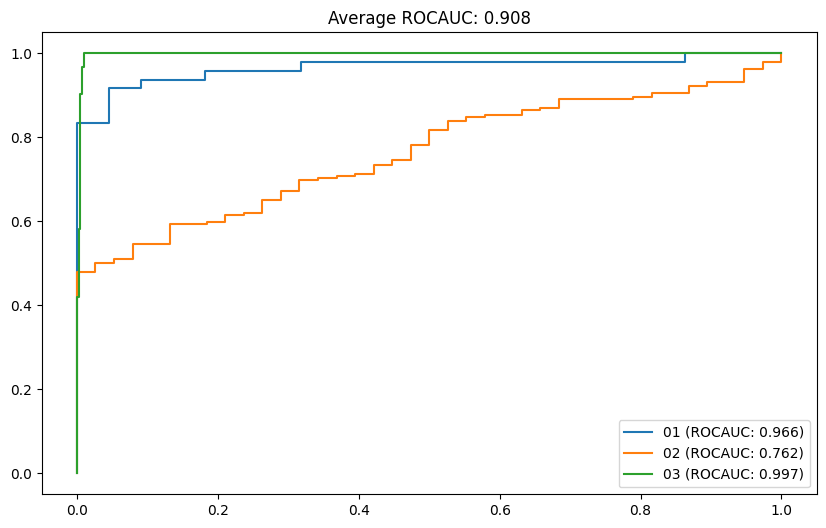

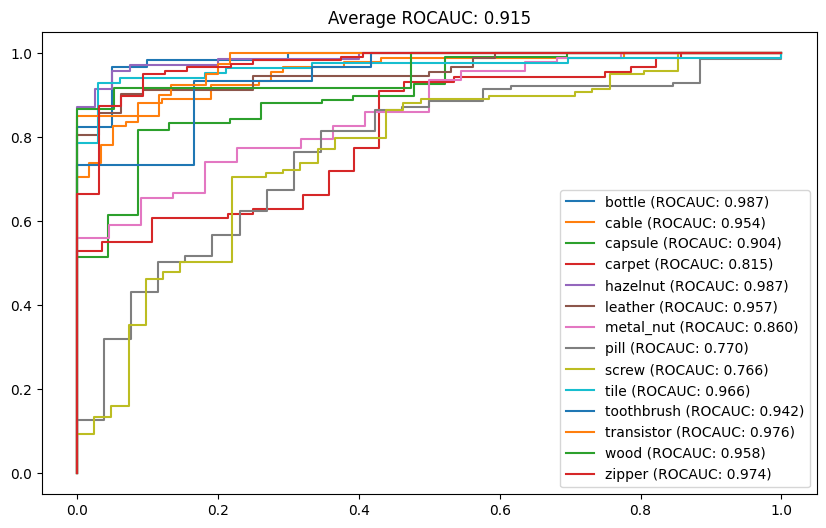

In [8]:
if __name__ == '__main__':
    main(dataset="BTAD", save_path="./btad_results")
    main(dataset="MVTec", root_path="/content/drive/MyDrive/mvtec", save_path="./mvtec_results")